# Cyberattack Detection

Plan:
- EDA
- random forest model
    - binary detection
    - multiclass detection

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# read data
train_df = pd.read_csv("../data/raw/UNSW_NB15_training-set.csv")
test_df = pd.read_csv("../data/raw/UNSW_NB15_testing-set.csv")
features_df = pd.read_csv("../data/raw/NUSW-NB15_features.csv", encoding='cp1252')

In [13]:
train_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [15]:
test_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [18]:
features_df

,No.,Name,Type,Description
0,1,srcip,nominal,Source IP address
1,2,sport,integer,Source port number
2,3,dstip,nominal,Destination IP address
3,4,dsport,integer,Destination port number
4,5,proto,nominal,Transaction protocol
5,6,state,nominal,Indicates to the state and its dependent proto...
6,7,dur,Float,Record total duration
7,8,sbytes,Integer,Source to destination transaction bytes
8,9,dbytes,Integer,Destination to source transaction bytes
9,10,sttl,Integer,Source to destination time to live value


# Data Exploration

In [ ]:
# confirm the train and test sets are similar
train_df.columns == test_df.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [20]:
train_df.shape

(82332, 45)

In [21]:
test_df.shape

(175341, 45)

In [23]:
train_df.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,82332.000000,82332.000000,8.233200e+04,...,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,41166.500000,1.006756,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,180.967667,95.713003,6.454902e+07,...,4.928898,3.663011,7.456360,0.008284,0.008381,0.129743,6.468360,9.164262,0.011126,0.550600
std,23767.345519,4.710444,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,101.513358,116.667722,1.798618e+08,...,8.389545,5.915386,11.415191,0.091171,0.092485,0.638683,8.543927,11.121413,0.104891,0.497436
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,20583.750000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,62.000000,0.000000,1.120247e+04,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,41166.500000,0.014138,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,254.000000,29.000000,5.770032e+05,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000
75%,61749.250000,0.719360,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,254.000000,252.000000,6.514286e+07,...,4.000000,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,1.000000
max,82332.000000,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,253.000000,5.268000e+09,...,59.000000,38.000000,63.000000,2.000000,2.000000,16.000000,60.000000,62.000000,1.000000,1.000000


In [24]:
test_df.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,175341.000000,175341.000000,175341.000000,175341.000000,1.753410e+05,1.753410e+05,1.753410e+05,175341.000000,175341.000000,1.753410e+05,...,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000
mean,87671.000000,1.359389,20.298664,18.969591,8.844844e+03,1.492892e+04,9.540619e+04,179.546997,79.609567,7.345403e+07,...,5.383538,4.206255,8.729881,0.014948,0.014948,0.133066,6.955789,9.100758,0.015752,0.680622
std,50616.731112,6.480249,136.887597,110.258271,1.747656e+05,1.436542e+05,1.654010e+05,102.940011,110.506863,1.883574e+08,...,8.047104,5.783585,10.956186,0.126048,0.126048,0.701208,8.321493,10.756952,0.124516,0.466237
min,1.000000,0.000000,1.000000,0.000000,2.800000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,43836.000000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,3.278614e+01,62.000000,0.000000,1.305334e+04,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
50%,87671.000000,0.001582,2.000000,2.000000,4.300000e+02,1.640000e+02,3.225807e+03,254.000000,29.000000,8.796748e+05,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,1.000000
75%,131506.000000,0.668069,12.000000,10.000000,1.418000e+03,1.102000e+03,1.250000e+05,254.000000,252.000000,8.888889e+07,...,5.000000,3.000000,12.000000,0.000000,0.000000,0.000000,9.000000,12.000000,0.000000,1.000000
max,175341.000000,59.999989,9616.000000,10974.000000,1.296523e+07,1.465555e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,...,51.000000,46.000000,65.000000,4.000000,4.000000,30.000000,60.000000,62.000000,1.000000,1.000000


In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [35]:
train_df.notna().value_counts()

id    dur   proto  service  state  spkts  dpkts  sbytes  dbytes  rate  sttl  dttl  sload  dload  sloss  dloss  sinpkt  dinpkt  sjit  djit  swin  stcpb  dtcpb  dwin  tcprtt  synack  ackdat  smean  dmean  trans_depth  response_body_len  ct_srv_src  ct_state_ttl  ct_dst_ltm  ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  attack_cat  label
True  True  True   True     True   True   True   True    True    True  True  True  True   True   True   True   True    True    True  True  True  True   True   True  True    True    True    True   True   True         True               True        True          True        True              True              True            True          True        True              True        True        True             True        True     82332
dtype: int64

In [36]:
test_df.notna().value_counts()

id    dur   proto  service  state  spkts  dpkts  sbytes  dbytes  rate  sttl  dttl  sload  dload  sloss  dloss  sinpkt  dinpkt  sjit  djit  swin  stcpb  dtcpb  dwin  tcprtt  synack  ackdat  smean  dmean  trans_depth  response_body_len  ct_srv_src  ct_state_ttl  ct_dst_ltm  ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  attack_cat  label
True  True  True   True     True   True   True   True    True    True  True  True  True   True   True   True   True    True    True  True  True  True   True   True  True    True    True    True   True   True         True               True        True          True        True              True              True            True          True        True              True        True        True             True        True     175341
dtype: int64

# Target Columns

In [30]:
train_df['attack_cat'].value_counts()

Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: attack_cat, dtype: int64

In [31]:
test_df['attack_cat'].value_counts()

Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: attack_cat, dtype: int64

In [32]:
train_df['label'].value_counts()

1    45332
0    37000
Name: label, dtype: int64

In [33]:
test_df['label'].value_counts()

1    119341
0     56000
Name: label, dtype: int64

> There is no need to split the data. it has already been split into ideal train and test sets

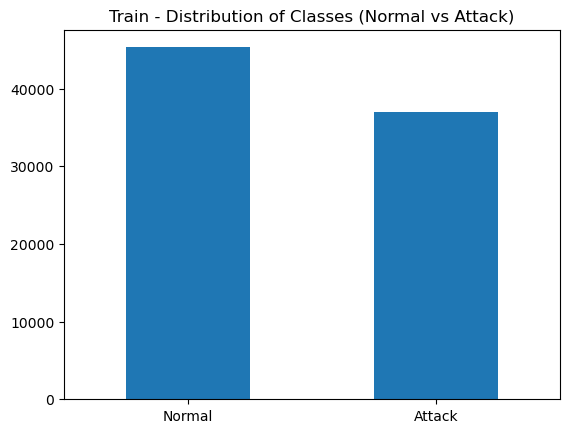

In [39]:
train_df['label'].value_counts().plot(
    kind='bar',
    title='Train - Distribution of Classes (Normal vs Attack)'
)
plt.xticks(
    [0, 1],
    ['Normal', 'Attack'],
    rotation=0
)
plt.show()

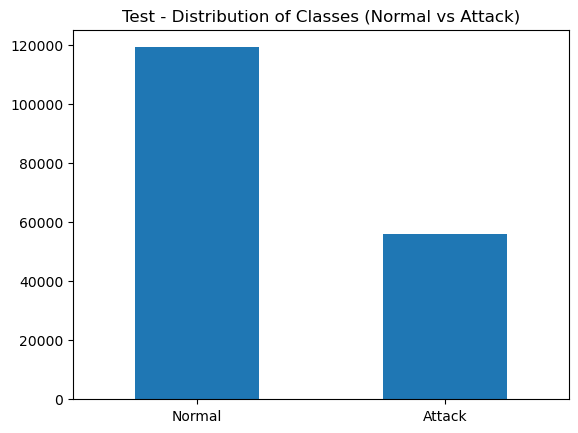

In [40]:
test_df['label'].value_counts().plot(
    kind='bar',
    title='Test - Distribution of Classes (Normal vs Attack)'
)
plt.xticks(
    [0, 1],
    ['Normal', 'Attack'],
    rotation=0
)
plt.show()

In [42]:
train_df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 